In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('intern_task.csv')

data.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [3]:
pd.Series(data.dtypes.unique())

0      int64
1    float64
dtype: object

Все данные представлены числами

In [4]:
data.isna().sum().sum()

0

Отстуствующих значение нет

Так как признаков довольно много (144), первая задача - посмотреть, возможно, присутствуют совершенно бесполезные.

In [5]:
data.nunique().sort_values().head(20)

feature_100     1
feature_72      1
feature_65      1
feature_64      1
feature_97      2
feature_96      2
feature_95      2
feature_98      2
feature_99      2
rank            5
feature_1      10
feature_3      10
feature_28     10
feature_33     11
feature_23     13
feature_2      15
feature_0      16
feature_4      16
feature_125    19
feature_27     24
dtype: int64

Признаки с одним уникальным значением - бесполезные, так как не содержат информации, удаляем.

Можно предположить, что признаки с малым количеством уникальных значений являются закодированными категориальными переменными.

In [6]:
data = data.drop(['feature_100', 'feature_72', 'feature_65', 'feature_64'], axis=1)

Не смотря на то, что признаков большое количество. Хочется оценить выбросы и распределения. Построим общие графики. Чтобы построить общий график, предварительно нормализуем данные.

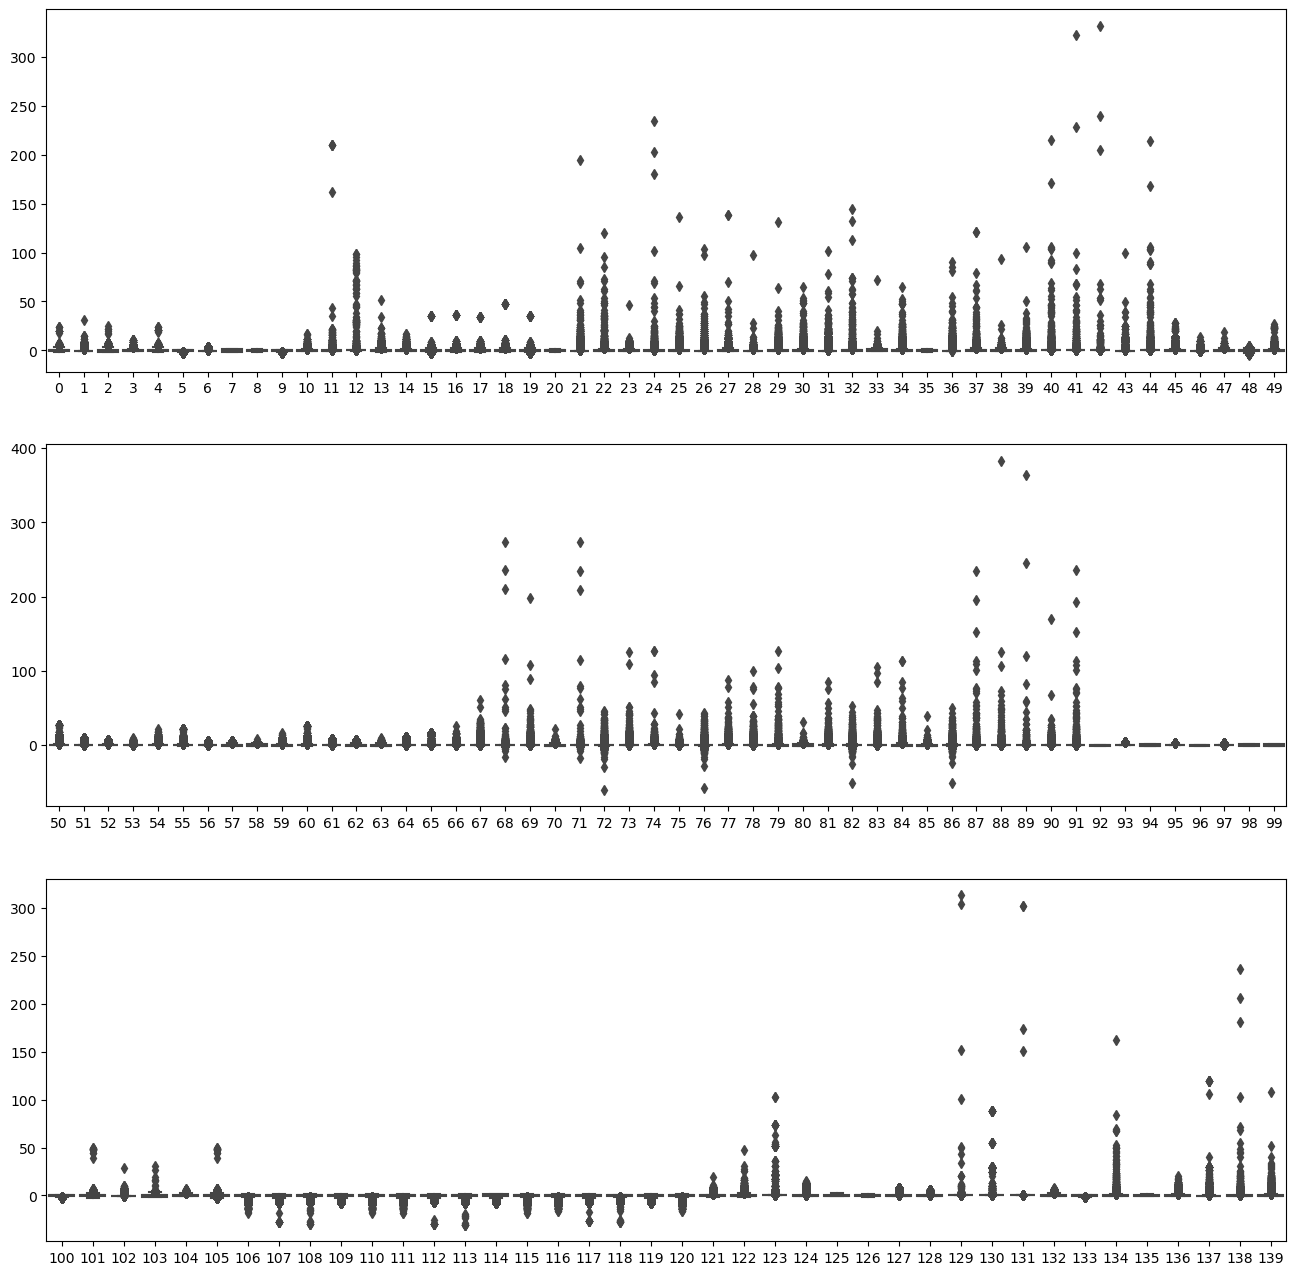

In [7]:
plt.figure(figsize=(16, 16))

features = data.columns[2:]
scaler = StandardScaler()
scaler_data = pd.DataFrame(scaler.fit_transform(data[features]))

plt.subplot(3, 1, 1)
sns.boxplot(scaler_data.iloc[:, :50])
plt.subplot(3, 1, 2)
sns.boxplot(scaler_data.iloc[:, 50:100])
plt.subplot(3, 1, 3)
sns.boxplot(scaler_data.iloc[:, 100:])
plt.show()

Есть признаки с большим количеством выбросов. Посмотроим на распределение таких признаков. Возможно, есть смысл логарифмировать их, чтобы сгладить значения, таким образом модель будет лучше дифференцировать различные значения.

In [8]:
n_out = []

for f in features:
    Q1 = data[f].quantile(0.25)
    Q3 = data[f].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out.append(data[(data[f] < lower) | data[f] > upper].shape[0] / data.shape[0])

out = pd.Series(n_out, index=features).sort_values(ascending=False)
out.head(20)

feature_140    0.914757
feature_59     0.914757
feature_49     0.914757
feature_55     0.885113
feature_60     0.885113
feature_45     0.885113
feature_54     0.733046
feature_50     0.699912
feature_57     0.698114
feature_62     0.698114
feature_47     0.698114
feature_69     0.628710
feature_141    0.614780
feature_136    0.397457
feature_58     0.397457
feature_63     0.397457
feature_52     0.383192
feature_42     0.368183
feature_67     0.368136
feature_43     0.221221
dtype: float64

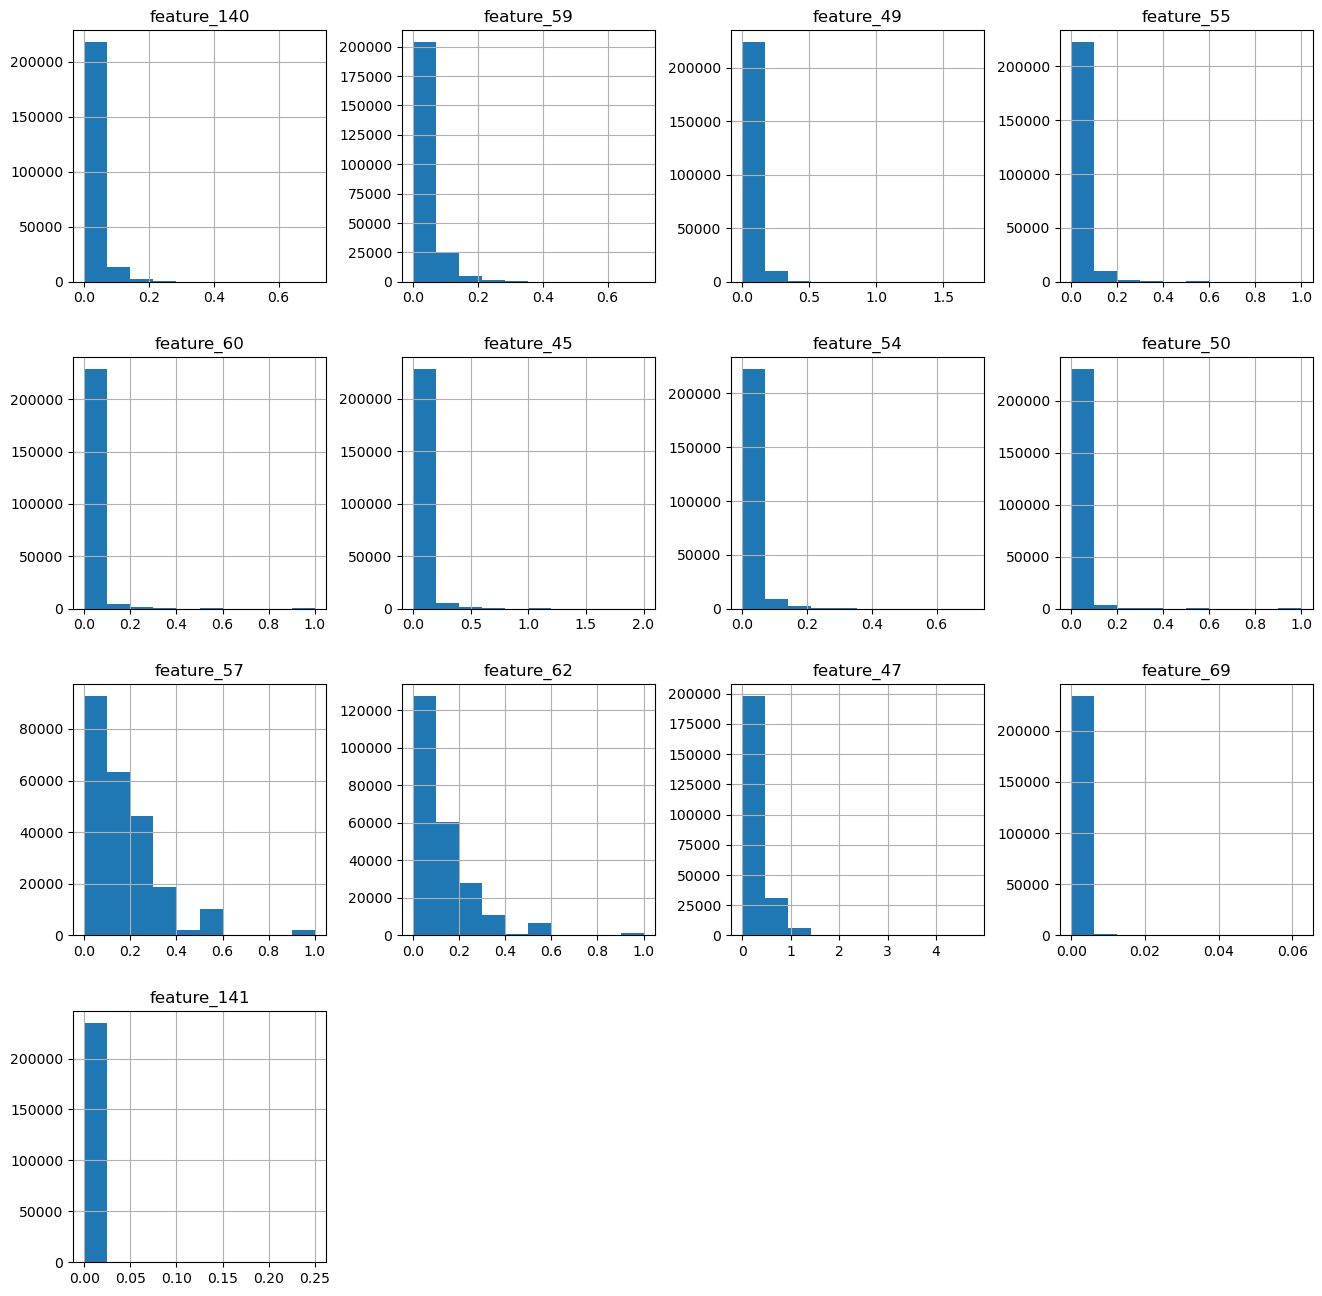

In [9]:
out_features = out[out > 0.5].index

data[out_features].hist(figsize=(16, 16))
plt.show()

Посмотрим на попарную корреляцию между признаками. Их много, но охватить домашнему компьютеру - реально, построим хитмап.

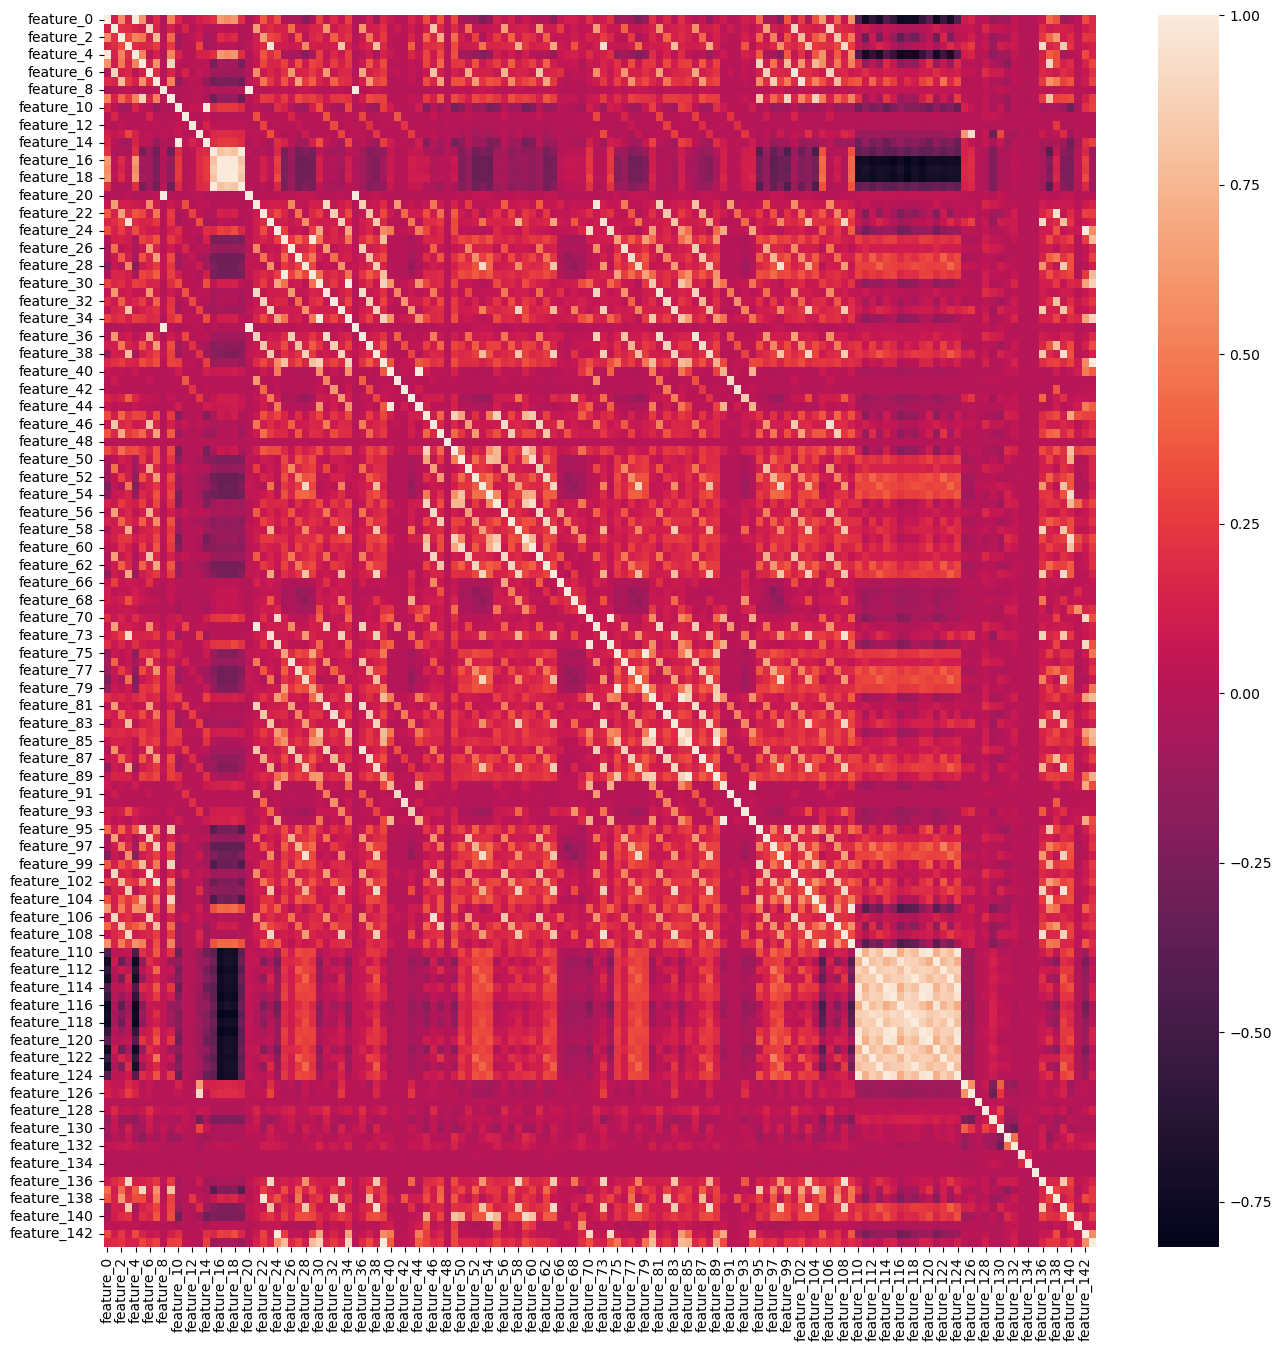

In [10]:
plt.figure(figsize=(16, 16))
sns.heatmap(data[features].corr())
plt.show()

Это не очень информативно, с точки зрения взаимодействия конкретных признаков. Но можно заметить, что в хитмап четко проглядывается рисунок. Можно предположить, что данные сгенерированы. Кроме того, мы видим, что есть признаки с существенной корреляцией.

С одной стороны, можно удалить коррелирующие признаки. Но необходимость этого, в любом случае, потом нужно проверять на тесте.

Есть другой путь, обучить PCA (метод главных компонент) и попробовать, максимально сохраняя дисперсию, уменьшить признаковое пространство. Целесообразность этого шага обязательно проверим на тесте.

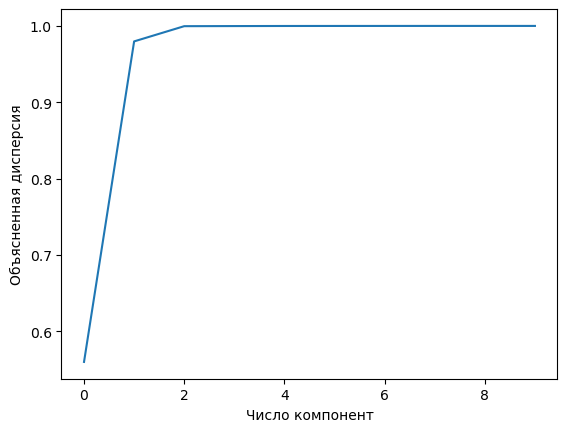

In [11]:
pca = PCA(n_components=10)
pca_data = pca.fit_transform(data[features])

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.xlabel('Число компонент')
plt.ylabel('Объясненная дисперсия')
plt.show()

In [12]:
cumulative_variance_ratio

array([0.56002025, 0.97974005, 0.99966774, 0.99980846, 0.99992086,
       0.9999541 , 0.99997767, 0.99999967, 0.99999981, 0.99999991])

10 компонент объясняют практически всю дисперсию. Попробуем обучить модель преобразовав признаковое пространство с помощью PCA. Позже, сравним обобщающую способность моделей обученных на всем количестве признаков (их не запредельное количество) и на меньшем признаковом пространстве.

Предварительный вывод:

1. В данных есть неинформативные признаки, удалим их
2. Похоже в данных есть зависимые признаки, они усложняют модель, но возможно могут иметь ценность. Попробуем использовать PCA. Если это даст плохой результат, может стоит посмотреть в сторону Lasso регрессии, чтобы удалить неважные признаки.
3. Выбросов много, при этом, есть подозрение, что данные на которых можель будет применяться будут такими же, и в целом, для градиентного бустинга это не так критично, поэтому попробуем обучить модель не очищая данные от выбросов.